## Visualize global admin0 and country level admin1 results

In this notebook we quickly plot the some resulting maps from the model putput for global admin0 results and country-level admin1 results.

Shapefiles for the counrty/admin1 borders can be accessed here: https://gadm.org/download_country.html
Shapefiles for global admin0 borders can be accessed here: https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/ or here: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

In [76]:
# load libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from cartopy import crs as ccrs
import seaborn as sns
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [111]:
# paths (to be adjusted when running on different machines)
results_path = '/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/results/'
shp_path = '/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/shapefiles/'
fig_save_path ='/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk/data/results/plots/'

# projection for plotting
robinson = ccrs.Robinson().proj4_init

In [243]:
def plot_admin1_values(csv_file, country, scenario, year, thresh, metric):
    """
    Plot regional values for the given country, scenario, year, threshold, and metric.
    
    Args:
    - csv_file: Path to the CSV file containing the data.
    - country: 3-digit ISO country code (e.g., 'USA').
    - scenario: Scenario string ['optimistic', 'medium', 'pessimistic', 'current'].
    - year: Year ['hist', 2050, 2100] (filtered by column "time_horizon").
    - thresh: Threshold level ['low', 'med', 'high'].
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    
    Returns:
    - A plot showing the admin1 regional values for the selected country and scenario.
    """
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(csv_file)
    
    df_clean = df[df['GID_1'].notna()]
    
    # Filter data based on input criteria
    df_filtered = df_clean[(df_clean['GID_1'].str.startswith(country)) & 
                     (df_clean['scenario'] == scenario) & 
                     (df_clean['time_horizon'] == year)]

    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'
    
    # Load shapefile
    gdf = gpd.read_file(f'{shp_path}/gadm41_{country}_shp/gadm41_{country}_1.shp')
    
    gdf = gdf[~gdf['GID_1'].str.contains('USA.2_')]
    # Merge it with filtered data
    gdf = gdf.merge(df_filtered, left_on='GID_1', right_on='GID_1', how='left')
    
    gdf = gdf.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    vmax_value = gdf[metric_column].max()
    # Plot the filtered geodataframe
    gdf.plot(column=metric_column, ax=ax, legend=True, cmap=cmap, vmax=vmax_value,
                                  edgecolor='black', linewidth=0.1)
    
    # Add title and remove axes
    ax.set_title(f'Displaced people ({metric} - {scenario} - {year} - {thresh})', fontsize=fontsize)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(f'{country}_{year}_{scenario}_{metric_column}.png', transparent=True)

### TC results

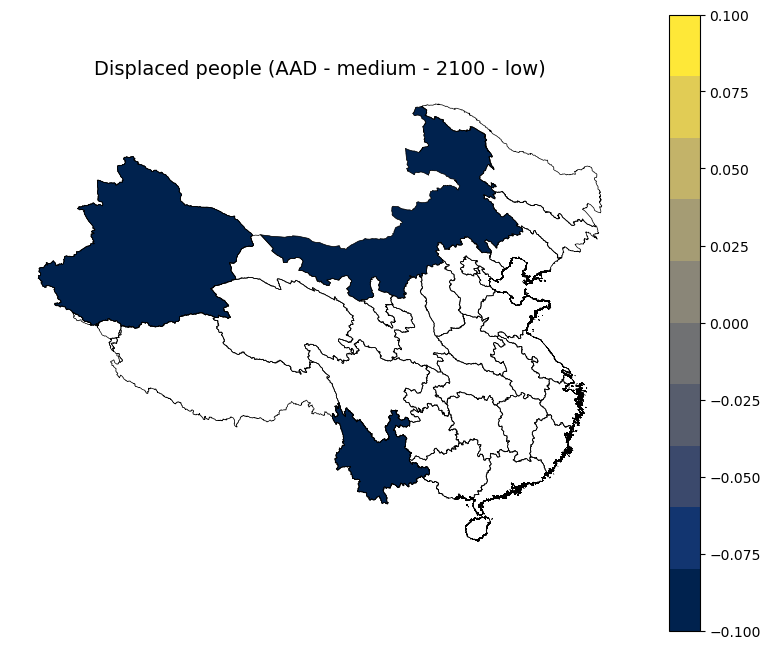

In [252]:
# Example usage:
plot_admin1_values(f'{results_path}displacement_risk_tc_global_admin1.csv', 'CHN', 'medium', '2100', 'low', 'AAD')

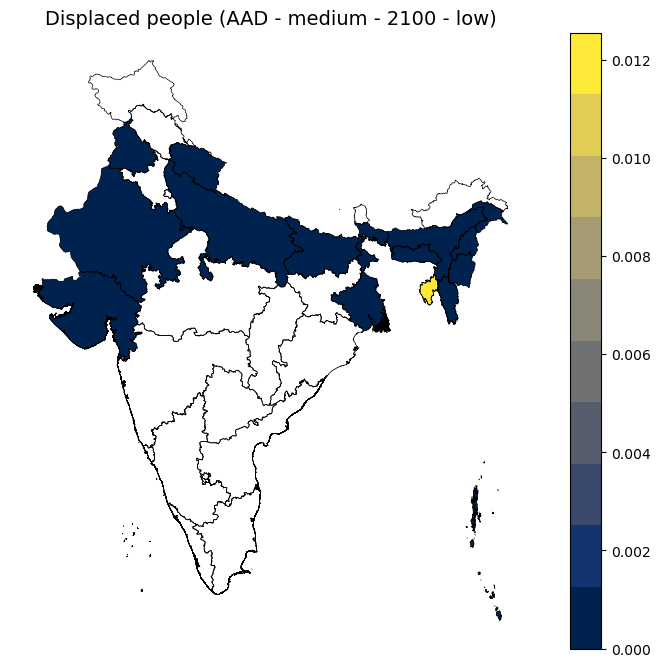

In [251]:
plot_admin1_values(f'{results_path}displacement_risk_tc_global_admin1.csv', 'IND', 'medium', '2100', 'low', 'AAD')

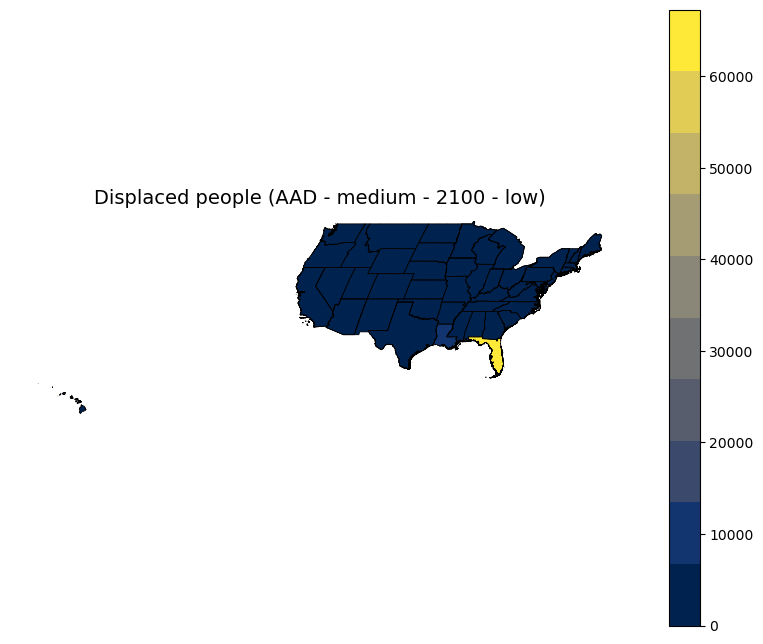

In [254]:
plot_admin1_values(f'{results_path}displacement_risk_tc_global_admin1.csv', 'USA', 'medium', '2100', 'low', 'AAD')

### Coastal flood results

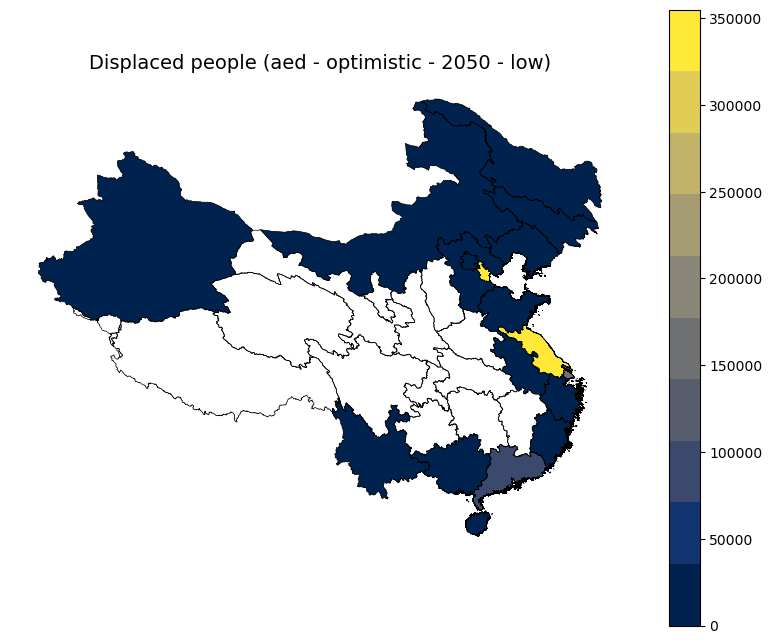

In [260]:
# Example usage:
plot_admin1_values(f'{results_path}displacement_risk_cf_global_admin1.csv', 'CHN', 'optimistic', 2050, 'low', 'aed')

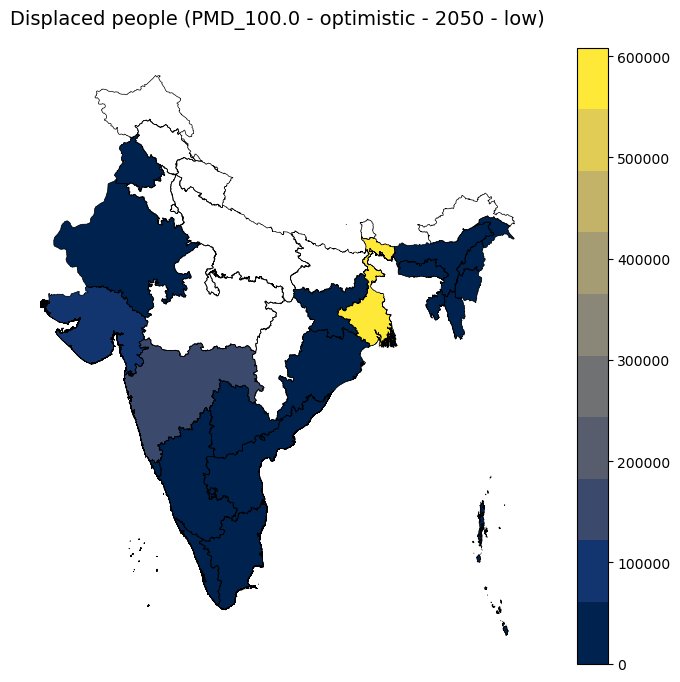

In [247]:
plot_admin1_values(f'{results_path}displacement_risk_cf_global_admin1.csv', 'IND', 'optimistic', 2050, 'low', 'PMD_100.0')

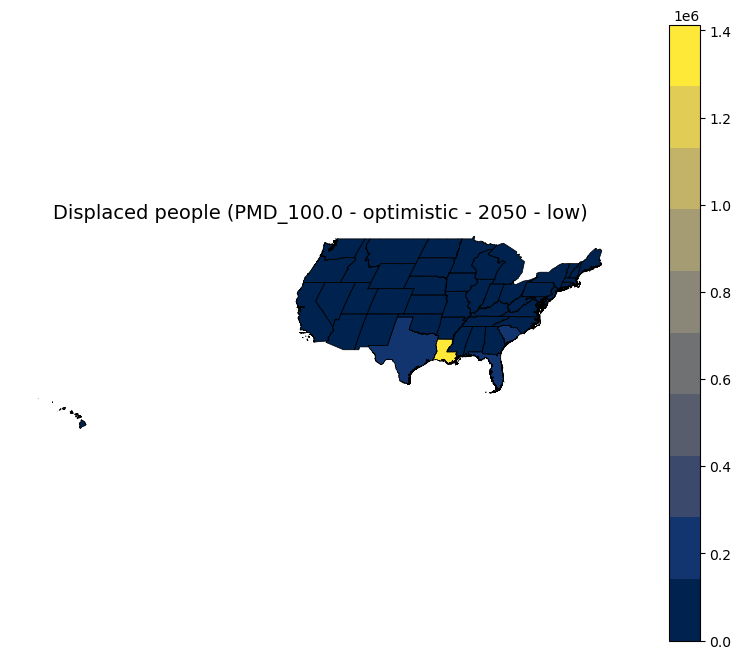

In [253]:
plot_admin1_values(f'{results_path}displacement_risk_cf_global_admin1.csv', 'USA', 'optimistic', 2050, 'low', 'PMD_100.0')

## Admin0

In [134]:
def plot_global_cf_admin0(csv_file, year, RCP, metric):
    """
    Plot a global map of admin0 results.
    
    Args:
    - csv_file: Path to the CSV file containing results.
    - year: Time period to filter (e.g., 2020, 2050, 2100).
    - RCP: Scenario to filter (e.g., 26, 45, 85).
    - metric: Metric to plot (e.g., 'AED', 'RP_10').
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Filter the data based on year and RCP
    df_filtered = df[(df['year'] == year) & (df['RCP'] == RCP)]
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the filtered results based on the ISO-3 country code
    world = world.merge(df_filtered, left_on='ISO_A3', right_on='iso3', how='left')
    
    # Ensure the metric is treated as continuous
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    # Get the maximum value for the metric column
    vmax_value = world[metric].max()
    
    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, vmax=vmax_value,
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    ax.set_title(f'Displaced people from coastal floods ({metric} - RCP{RCP} - {year})', fontsize=16)
    
    # Remove axis
    ax.set_axis_off()
    
    # Show the plot
    plt.show()


def plot_global_tc_admin0(csv_file, period, scenario, metric):
    """
    Plot a global map of admin0 results.
    
    Args:
    - csv_file: Path to the CSV file containing results.
    - period: Time period to filter (e.g., 'hist', '2050').
    - scenario: Scenario to filter (e.g., 'ERA-5', 'ssp245').
    - metric: Metric to plot (e.g., 'AAD', 'RP_10').
    """
    # Load the results data
    df = pd.read_csv(csv_file)
    
    # Filter the data based on period and scenario
    df_filtered = df[(df['Period'] == period) & (df['Scenario'] == scenario)]
    
    # Load the world shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge with the filtered results based on the ISO-3 country code
    world = world.merge(df_filtered, left_on='ISO_A3', right_on='iso3', how='left')
    
    # Ensure the metric is treated as continuous
    world[metric] = pd.to_numeric(world[metric], errors='coerce')
    
    # Reproject the world shapefile to Robinson projection
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot the boundaries first (outlines)
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    # Get the maximum value for the metric column
    vmax_value = world[metric].max()
    
    # Plot the filled polygons with the data (after the borders are drawn)
    world.plot(column=metric, ax=ax, legend=True, cmap=cmap, vmax=vmax_value,
                                  edgecolor='black', linewidth=0.1)
    
    # Set the title
    ax.set_title(f'Displaced people from tropical cyclones ({metric} - {scenario} - {period})', fontsize=16)
    
    # Remove axis
    ax.set_axis_off()
    
    # Show the plot
    plt.show()


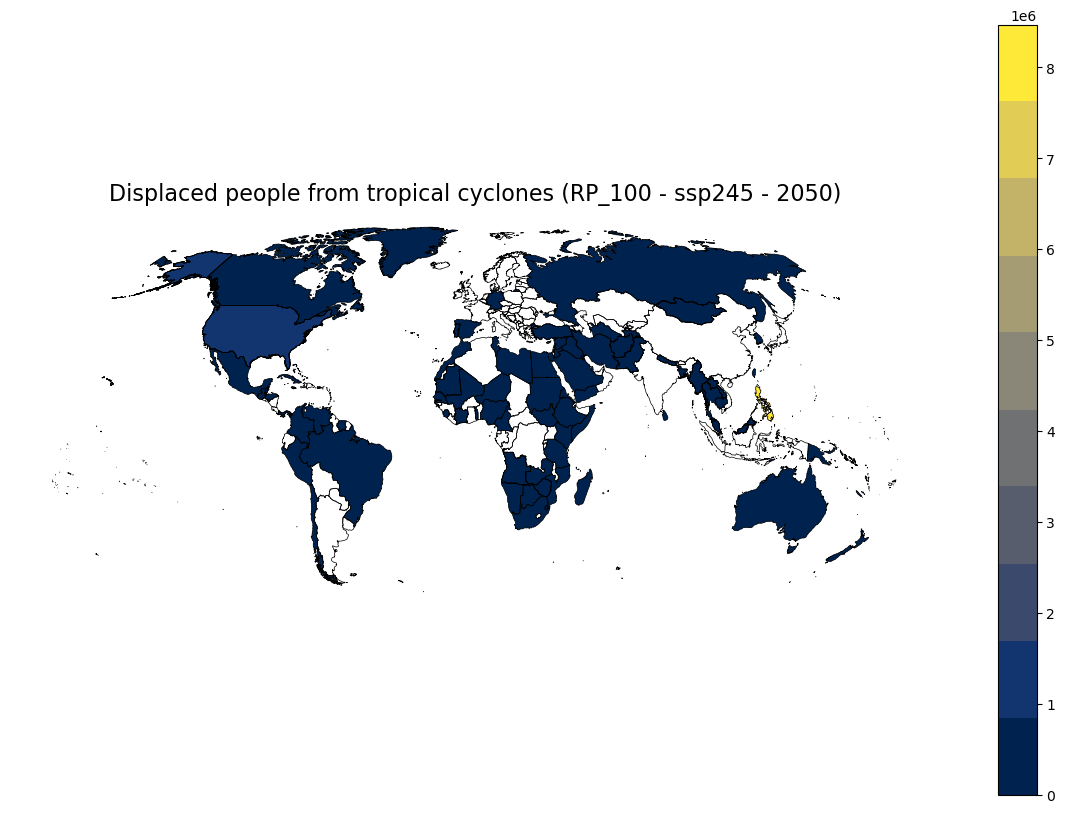

In [136]:
plot_global_tc_admin0(f'{results_path}displacement_risk_tc_global_admin0.csv', '2050', 'ssp245', 'RP_100')

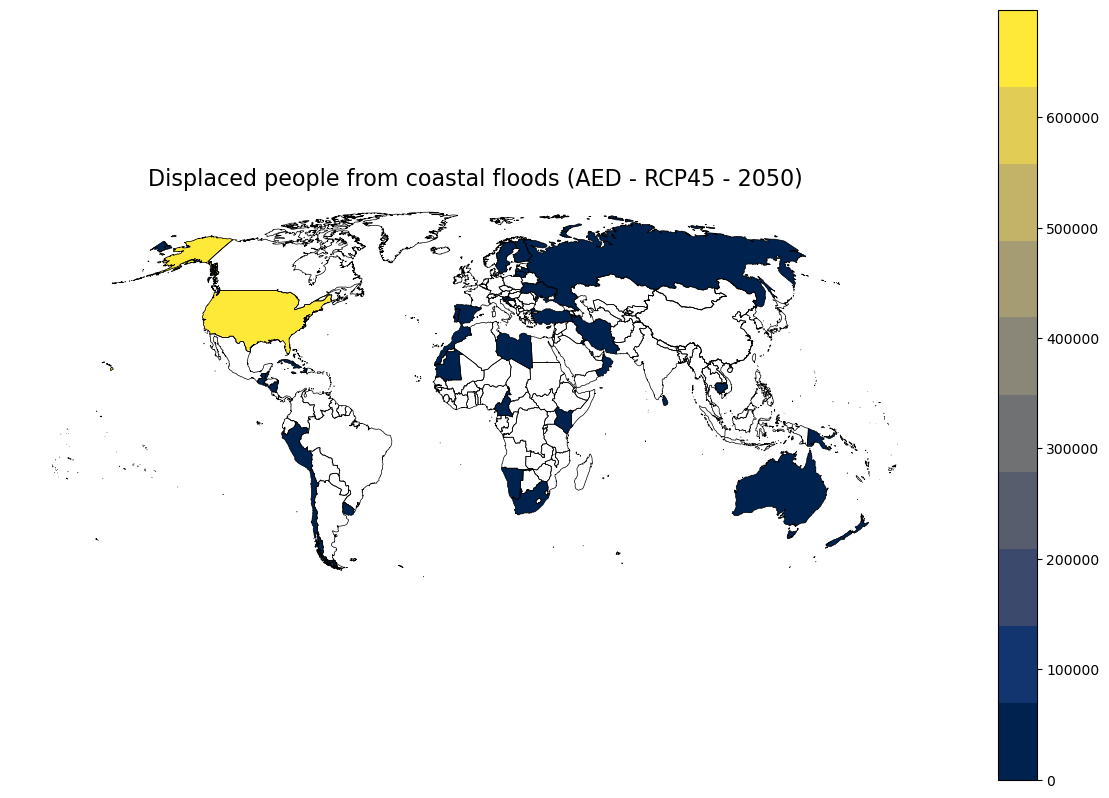

In [135]:
plot_global_cf_admin0(f'{results_path}displacement_risk_cf_global_admin0.csv', 2050, 45, 'AED')

#### Aggretated admin0 values from admin1 files

In [178]:
def plot_admin0_values(csv_file, scenario, year, thresh, metric):
    """
    Plot regional values for the given country, scenario, year, threshold, and metric.
    
    Args:
    - csv_file: Path to the CSV file containing the data.
    - scenario: Scenario string ['optimistic', 'medium', 'pessimistic', 'current'].
    - year: Year ['hist', 2050, 2100] (filtered by column "time_horizon").
    - thresh: Threshold level ['low', 'med', 'high'].
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    
    Returns:
    - A plot showing the admin1 regional values for the selected country and scenario.
    """
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(csv_file)
    
    df_clean = df[df['GID_1'].notna()]
    
    # Filter data based on scenario and year
    df_filtered = df[(df['scenario'] == scenario) & (df['time_horizon'] == year)]
    
    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'
    
    # Extract ISO-3 codes by taking the first three characters of 'GID_1'
    df_filtered['ISO3'] = df_filtered['GID_1'].str[:3]
    
    # Group by ISO-3 code and sum the admin1 values for the given metric_thresh
    df_aggregated = df_filtered.groupby('ISO3')[metric_column].sum().reset_index()

    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'

    # Load the world admin0 shapefile
    world = gpd.read_file(f'{shp_path}ne_50m_admin_0_countries')
    
    # Remove Antarctica from the shapefile
    world = world[world['ISO_A3'] != 'ATA']
    
    # Merge the aggregated data with the world shapefile on ISO-3 country codes
    world = world.merge(df_aggregated, left_on='ISO_A3', right_on='ISO3', how='left')

    
    world = world.to_crs(robinson)

    # Plot using the provided example style
    fontsize = 14
    fig, ax = plt.subplots(figsize=(10, 8))
    world.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    vmax_value = world[metric_column].max()
    # Plot the filtered geodataframe
    world.plot(column=metric_column, ax=ax, legend=True, cmap=cmap, vmax=vmax_value,
                                  edgecolor='black', linewidth=0.1)
    
    # Add title and remove axes
    ax.set_title(f'Displaced people ({metric} - {scenario} - {year} - {thresh})', fontsize=fontsize)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    
    # Save plot
    #plt.savefig(f'{country}_{year}_{scenario}_{metric_column}.png', transparent=True)

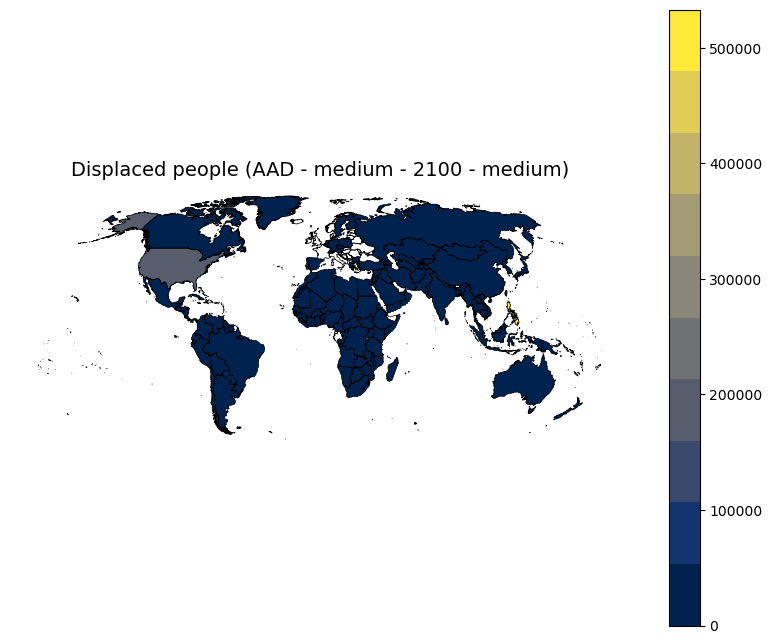

In [255]:
plot_admin0_values(f'{results_path}displacement_risk_tc_global_admin1.csv', 'medium', '2100', 'medium', 'AAD')

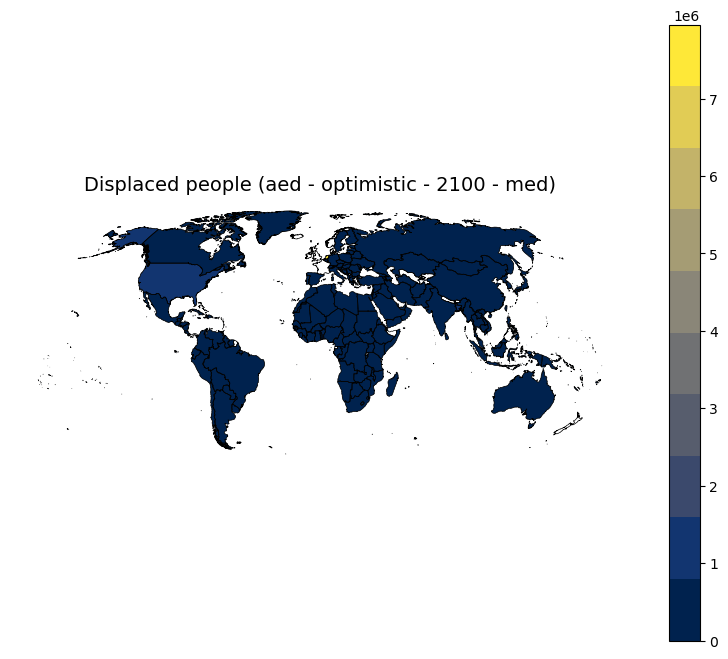

In [261]:
plot_admin0_values(f'{results_path}displacement_risk_cf_global_admin1.csv', 'optimistic', 2100, 'med', 'aed')

### Plots global admin1 results

needs more work...
particularly: find a global shapefile with admin1 region info that matches the results csv files

In [250]:
def plot_global_admin1_values(csv_file, scenario, year, thresh, metric):
    """
    Plot regional values for the given country, scenario, year, threshold, and metric.
    
    Args:
    - csv_file: Path to the CSV file containing the data.
    - scenario: Scenario string ['optimistic', 'medium', 'pessimistic', 'current'].
    - year: Year ['hist', 2050, 2100] (filtered by column "time_horizon").
    - thresh: Threshold level ['low', 'med', 'high'].
    - metric: Metric type ['AAD', 'PMD_10', 'PMD_25', 'PMD_50', 'PMD_100', 'PMD_250'].
    
    Returns:
    - A plot showing the admin1 regional values for the selected country and scenario.
    """
    # Load CSV file into pandas DataFrame
    df = pd.read_csv(csv_file)
    
    df_clean = df[df['fid'].notna()]
    
    # Filter data based on scenario and year
    df_filtered = df[(df['scenario'] == scenario) & (df['time_horizon'] == year)]
    
    # Create the column name based on metric and threshold
    metric_column = f'{metric}_{thresh}'
    
    # Remove Antarctica from the shapefile
    #world = world[world['ISO_A3'] != 'ATA']
    
     # Load the global admin1 shapefile
    admin1 = gpd.read_file(f'{shp_path}gadm_410-levels.gpkg')
    
    # Merge the CSV data with the admin1 shapefile using GID_1
    merged_gdf = admin1.merge(df_filtered, left_on='GID_1', right_on='GID_1', how='left')
    
    # Check and reproject to Robinson projection if needed
    robinson = "+proj=robin"
    merged_gdf = merged_gdf.to_crs(robinson)
    
    # Plot the results
    fontsize = 14
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Color map for the plot
    cmap = matplotlib.cm.get_cmap('cividis', 10)
    
    # Get the maximum value for the metric column to set the colorbar range
    vmax_value = merged_gdf[metric_column].max()
    
    # Plot the admin1 regions with the filtered data
    merged_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)  # Ensures borders are shown
    merged_gdf.plot(column=metric_column, ax=ax, legend=True, cmap=cmap, vmax=vmax_value, 
                    edgecolor='black', linewidth=0.1)
    
    # Add title and remove axes
    ax.set_title(f'Displaced people ({metric} - {scenario} - {year} - {thresh})', fontsize=fontsize)
    sns.despine(left=True, bottom=True)
    ax.set_axis_off()
    
    # Show the plot
    plt.show()


In [224]:
plot_global_admin1_values(f'{results_path}displacement_risk_tc_global_admin1.csv', 'medium', '2100', 'medium', 'AAD')

KeyError: 'GID_1'

In [218]:
admin1 = gpd.read_file(f'{shp_path}gadm_410-levels.gpkg')

<Axes: >

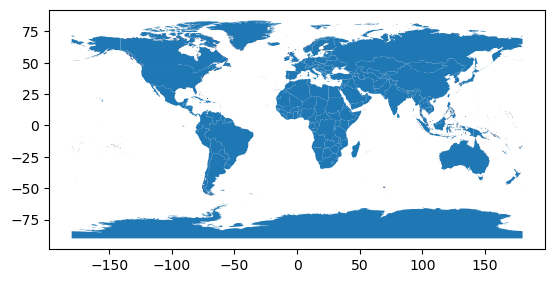

In [262]:
admin1.plot()

In [219]:
np.unique([admin1.columns])

array(['COUNTRY', 'GID_0', 'geometry'], dtype=object)

In [220]:
admin1

,GID_0,COUNTRY,geometry
0,ABW,Aruba,"MULTIPOLYGON (((-69.97820 12.46986, -69.97847 ..."
1,AFG,Afghanistan,"MULTIPOLYGON (((63.61554 29.46970, 63.61425 29..."
2,AGO,Angola,"MULTIPOLYGON (((19.89892 -17.87674, 19.89082 -..."
3,AIA,Anguilla,"MULTIPOLYGON (((-63.02064 18.20750, -63.02587 ..."
4,ALA,Åland,"MULTIPOLYGON (((21.32306 59.74847, 21.32306 59..."
...,...,...,...
258,YEM,Yemen,"MULTIPOLYGON (((44.12514 12.63236, 44.12542 12..."
259,ZAF,South Africa,"MULTIPOLYGON (((19.66291 -34.78653, 19.66327 -..."
260,ZMB,Zambia,"MULTIPOLYGON (((25.87834 -17.97218, 25.87034 -..."
261,ZNC,Northern Cyprus,"MULTIPOLYGON (((33.10775 35.15992, 33.09934 35..."
